# Evaluation COVID19 Data for the city of Aachen

In [2]:
%matplotlib inline
import numpy as np
import pandas
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

DATA_SRC = '../data/csv/Aachen.csv'
EXPORT_PLOT = True

raw_data = pandas.read_csv(DATA_SRC)
print(raw_data)

           Date  Cases  Active Cases
0    20.02.2020      0           NaN
1    28.02.2020      0           NaN
2    29.02.2020      1           NaN
3    01.03.2020      4           NaN
4    02.03.2020      4           NaN
..          ...    ...           ...
191  23.11.2020   4100         468.0
192  24.11.2020   4159         431.0
193  25.11.2020   4226         444.0
194  26.11.2020   4241         413.0
195  27.11.2020   4325         460.0

[196 rows x 3 columns]


## Clean up data-set and calculate desired data to plot

First we need to clean up our dataset and calculate direved quantities from our raw data. We will proceed with the following steps:
- Complete missing datapoints (days), by assigning the available data from the predecessor
- Calculate the number of new cases per day
- Calculate the number of new active cases per day
- Calculate the seven days incidence per 100k inhibitants
- Calculate the rolling averages for the above quantities

Let's start with adding missing data points.

In [3]:
# Complete datapoint of total cases
data = pandas.DataFrame({'Date':[], 'Cases':[], 'Active Cases':[]})
for index in range(len(raw_data['Date'])-1):
    # Add current datapoint
    data = data.append({'Date': raw_data['Date'][index], 'Cases': raw_data['Cases'][index], 'Active Cases': raw_data['Active Cases'][index]},
                       ignore_index=True)
    
    date = datetime.strptime(raw_data['Date'][index], '%d.%m.%Y')
    next_date = datetime.strptime(raw_data['Date'][index+1], '%d.%m.%Y')
    date_delta =  date - next_date

    # If days in list are missing, add them with data from predecessor
    if (abs(date_delta.days) > 1):
        for j in range(1,abs(date_delta.days)):
            new_date = date + timedelta(days=j)
            new_date_str = new_date.strftime('%d.%m.%Y')
            data = data.append({'Date': new_date_str, 'Cases': raw_data['Cases'][index], 'Active Cases': raw_data['Active Cases'][index]},
                               ignore_index=True)

data = data.append({'Date': raw_data['Date'].iloc[-1], 'Cases': raw_data['Cases'].iloc[-1], 'Active Cases': raw_data['Active Cases'].iloc[-1]},
                   ignore_index=True)

print(data)

           Date   Cases  Active Cases
0    20.02.2020     0.0           NaN
1    21.02.2020     0.0           NaN
2    22.02.2020     0.0           NaN
3    23.02.2020     0.0           NaN
4    24.02.2020     0.0           NaN
..          ...     ...           ...
277  23.11.2020  4100.0         468.0
278  24.11.2020  4159.0         431.0
279  25.11.2020  4226.0         444.0
280  26.11.2020  4241.0         413.0
281  27.11.2020  4325.0         460.0

[282 rows x 3 columns]


Next, we calculate the new cases per day as well as the seven days incidence.

For the seven days incidencs, we use the total number of inhibitants (248.960) from [*Landesdatenbank NRW*](https://www.landesdatenbank.nrw.de/ldbnrw/online;jsessionid=FBC481AAC50656B8CA9E933111BC242A.ldb2?sequenz=tabelleErgebnis&selectionname=12411-31iz)

In [4]:
# Helper function
def get_new_cases(array, offset):
    for index in range(offset, len(data['Cases'])):
        cases = int(data['Cases'][index])
        cases_min_days = int(data['Cases'][index-offset])
        array.append(cases - cases_min_days)
    
# New cases per seven days
new_cases_7days = [0,0,0,0,0,0]
get_new_cases(new_cases_7days, 6)
data['New cases per 7 days'] = new_cases_7days

# New cases per day
new_cases_per_day = [0]
get_new_cases(new_cases_per_day, 1)
data['New cases per day'] = new_cases_per_day

# Seven days incidencs
inhibs_100k = 2.4896
incidence = []
for cases_per_7days in data['New cases per 7 days']:
    incidence.append(cases_per_7days/inhibs_100k)
data['Incidence'] = incidence

# Rolling mean for seven days incidence
rolling_data = data.rolling(7).mean()
rolling_data['Date'] = data['Date']

# Print dataset for checking correctness
print(data)
print(rolling_data)

           Date   Cases  Active Cases  New cases per 7 days  \
0    20.02.2020     0.0           NaN                     0   
1    21.02.2020     0.0           NaN                     0   
2    22.02.2020     0.0           NaN                     0   
3    23.02.2020     0.0           NaN                     0   
4    24.02.2020     0.0           NaN                     0   
..          ...     ...           ...                   ...   
277  23.11.2020  4100.0         468.0                   332   
278  24.11.2020  4159.0         431.0                   319   
279  25.11.2020  4226.0         444.0                   276   
280  26.11.2020  4241.0         413.0                   246   
281  27.11.2020  4325.0         460.0                   330   

     New cases per day   Incidence  
0                    0    0.000000  
1                    0    0.000000  
2                    0    0.000000  
3                    0    0.000000  
4                    0    0.000000  
..                 ..

## Plotting the data

Now we are able to plot the data.

### Total number of cases

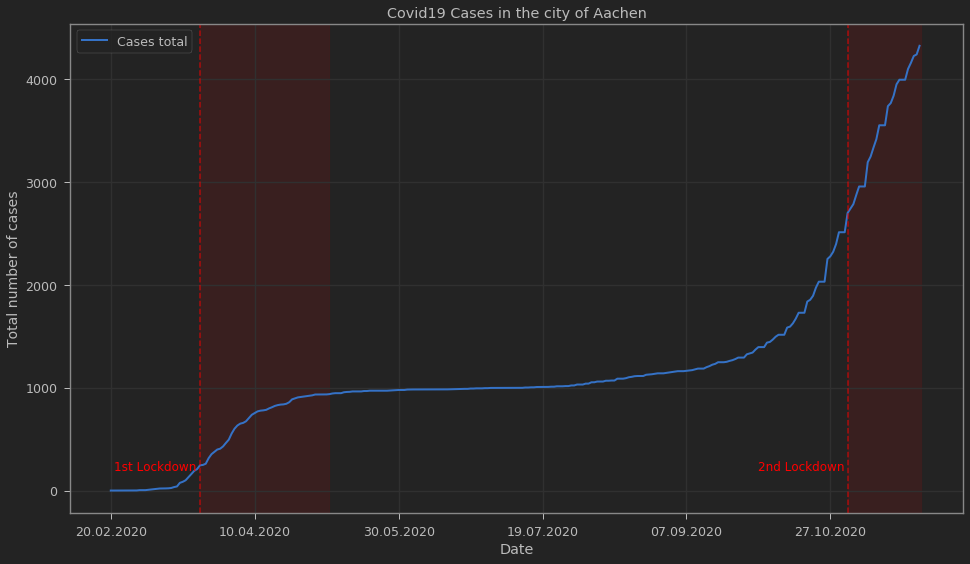

In [5]:
fig, ax = plt.subplots(figsize=(16,9))

data.plot(y='Cases', x='Date', ax=ax, linewidth=2)
ax.legend(['Cases total'])
ax.grid()
ax.set_ylabel('Total number of cases', fontsize=14)
ax.set_title('Covid19 Cases in the city of Aachen')

# Plot line for start of first lockdown
start_lockdown_1 = data.index[data['Date'] == '22.03.2020'][0]
end_lockdown_1 = data.index[data['Date'] == '06.05.2020'][0]
ax.axvline(start_lockdown_1, color='red', linestyle='--', alpha=0.6)
ax.text(1,200,'1st Lockdown', color='red', fontsize=12)
ax.axvspan(start_lockdown_1, end_lockdown_1, color='red', alpha=0.1)

# Plot line for start of second lockdown
ax.text(225,200,'2nd Lockdown', color='red', fontsize=12)
start_lockdown_2 = data.index[data['Date'] == '02.11.2020'][0]
end_lockdown_2 = len(data['Date'])
ax.axvline(start_lockdown_2, color='red', linestyle='--', alpha=0.6)
ax.axvspan(start_lockdown_2, end_lockdown_2, color='red', alpha=0.1)

if EXPORT_PLOT:
    plt.savefig('../data/evaluations/total_cases.png')

### New cases per day & seven days incidence

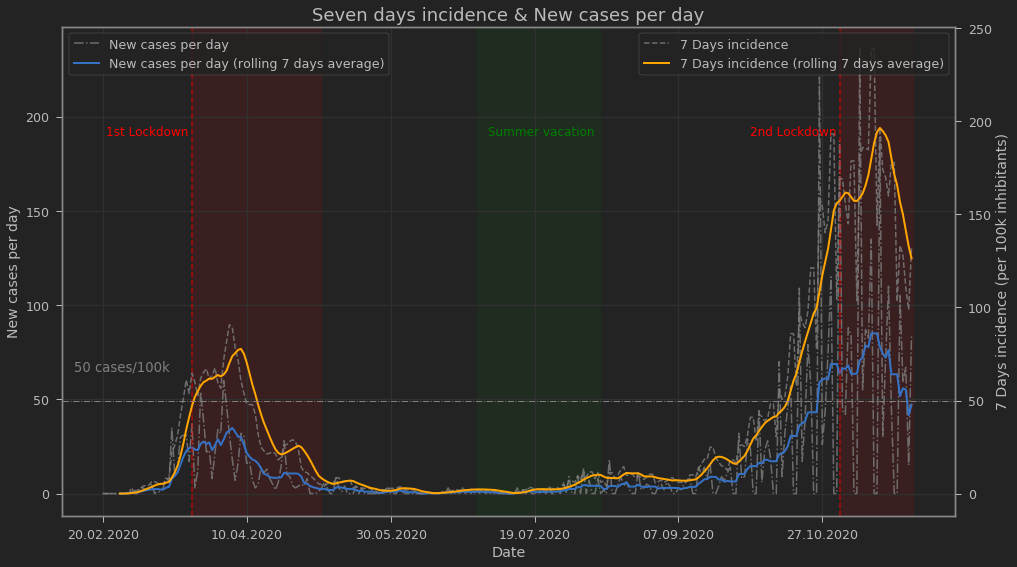

In [6]:
fig, ax = plt.subplots(figsize=(16,9))
ax.set_title('Seven days incidence & New cases per day', fontsize=18)

data.plot(y='New cases per day', x='Date', ax=ax, linestyle='-.', color='grey', alpha=0.8)
rolling_data.plot(y='New cases per day', x='Date', ax=ax, linewidth=2)
ax.set_ylabel('New cases per day', fontsize=14)

ax2 = ax.twinx()
data.plot(y='Incidence', x='Date', ax=ax2, linestyle='--', color='grey', alpha=0.8)
rolling_data.plot(y='Incidence', x='Date', ax=ax2, linewidth=2, color='orange')
ax.grid()
ax.legend(['New cases per day','New cases per day (rolling 7 days average)'], loc='upper left')
ax2.legend(['7 Days incidence','7 Days incidence (rolling 7 days average)'], loc='upper right')
ax2.set_ylabel('7 Days incidence (per 100k inhibitants)', fontsize=14)
ax2.axhline(50, color='grey', linestyle='-.', linewidth=1)

# Plot line for start of first lockdown
start_lockdown_1 = data.index[data['Date'] == '22.03.2020'][0]
end_lockdown_1 = data.index[data['Date'] == '06.05.2020'][0]
ax.axvline(start_lockdown_1, color='red', linestyle='--', alpha=0.6)
ax.text(1,190,'1st Lockdown', color='red', fontsize=12)
ax.axvspan(start_lockdown_1, end_lockdown_1, color='red', alpha=0.1)
ax.text(-10, 65, '50 cases/100k', color='grey')

# Plot line for start of second lockdown
ax.text(225,190,'2nd Lockdown', color='red', fontsize=12)
start_lockdown_2 = data.index[data['Date'] == '02.11.2020'][0]
end_lockdown_2 = len(data['Date'])
ax.axvline(start_lockdown_2, color='red', linestyle='--', alpha=0.6)
ax.axvspan(start_lockdown_2, end_lockdown_2, color='red', alpha=0.1)

# Plot summer vacation
start_vacation = data.index[data['Date'] == '29.06.2020'][0]
end_vacation = data.index[data['Date'] == '11.08.2020'][0]
ax.axvspan(start_vacation, end_vacation, color='green', alpha=0.1)
ax.text(134,190,'Summer vacation', color='green', fontsize=12)

# Save figure
if EXPORT_PLOT:
    plt.savefig('../data/evaluations/sevendays.png')
    

## Active cases

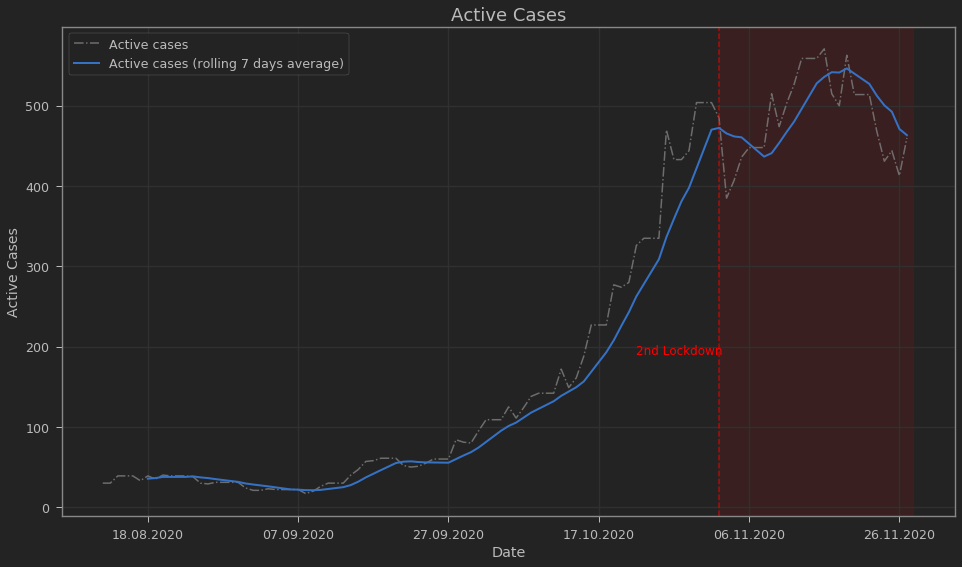

In [7]:
fig, ax = plt.subplots(figsize=(16,9))
ax.set_title('Active Cases', fontsize=18)

data.plot(y='Active Cases', x='Date', ax=ax, linestyle='-.', color='grey', alpha=0.8)
rolling_data.plot(y='Active Cases', x='Date', ax=ax, linewidth=2)
ax.set_ylabel('Active Cases', fontsize=14)
ax.grid()
ax.legend(['Active cases','Active cases (rolling 7 days average)'], loc='upper left')

# Plot line for start of second lockdown
start_lockdown_2 = data.index[data['Date'] == '02.11.2020'][0]
ax.text(start_lockdown_2-11,190,'2nd Lockdown', color='red', fontsize=12)
end_lockdown_2 = len(data['Date'])
ax.axvline(start_lockdown_2, color='red', linestyle='--', alpha=0.6)
ax.axvspan(start_lockdown_2, end_lockdown_2, color='red', alpha=0.1)

if EXPORT_PLOT:
    plt.savefig('../data/evaluations/active_cases.png')

## Compare path during lockdowns

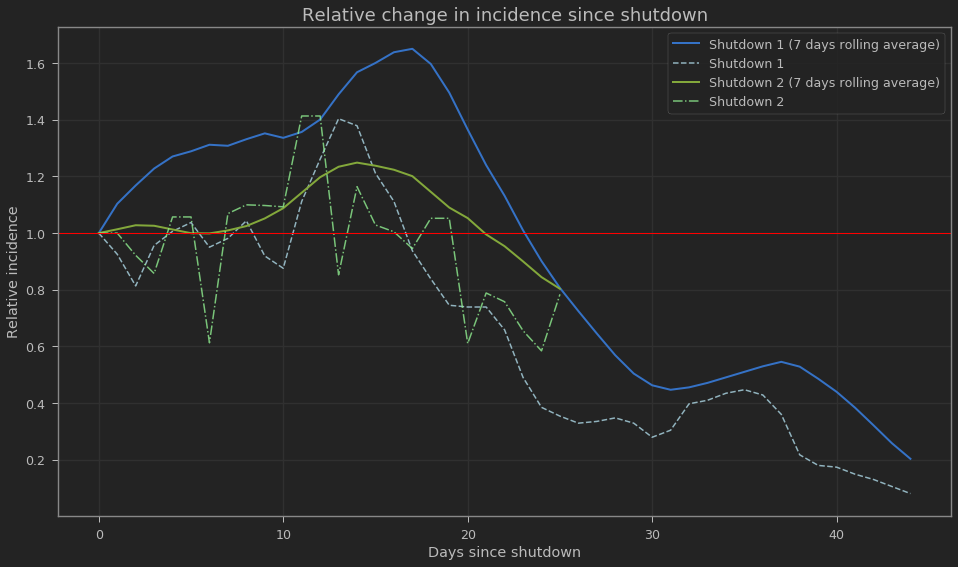

In [8]:
reference_1_rolling = rolling_data['Incidence'][start_lockdown_1]
reference_2_rolling = rolling_data['Incidence'][start_lockdown_2]
reference_1 = data['Incidence'][start_lockdown_1]
reference_2 = data['Incidence'][start_lockdown_2]

lockdown_1_rolling = []
lockdown_2_rolling = []
lockdown_1 = []
lockdown_2 = []

for i in range(end_lockdown_1 - start_lockdown_1):
    lockdown_1_rolling.append(rolling_data['Incidence'][start_lockdown_1 + i]/reference_1_rolling)
    lockdown_1.append(data['Incidence'][start_lockdown_1 + i]/reference_1)

for i in range(len(data['Date']) - start_lockdown_2):
    lockdown_2.append(data['Incidence'][start_lockdown_2 + i]/reference_2)
    lockdown_2_rolling.append(rolling_data['Incidence'][start_lockdown_2 + i]/reference_2_rolling)

fig, ax = plt.subplots(figsize=(16,9))
ax.set_title('Relative change in incidence since shutdown', fontsize=18)
ax.plot(lockdown_1_rolling, linewidth='2')
ax.plot(lockdown_1, color='lightblue', linestyle='--', alpha=0.8)
ax.plot(lockdown_2_rolling, linewidth='2')
ax.plot(lockdown_2, color='lightgreen', linestyle='-.', alpha=0.8)
ax.grid()
ax.legend(['Shutdown 1 (7 days rolling average)','Shutdown 1','Shutdown 2 (7 days rolling average)',  'Shutdown 2'])
ax.set_xlabel('Days since shutdown')
ax.set_ylabel('Relative incidence')
ax.axhline(1.0, color='red', linestyle='-', linewidth=1)

if EXPORT_PLOT:
    plt.savefig('../data/evaluations/relative_incidence.png')